# Exploring Australian Radar Data

_In this tutorial you'll learn how to access the Australia weather radar dataset, creating animations, ploting using interactive webmaps and run a hail size retrieval_

### Section 4.1 Topics

1. Overview of Australian Radar Dataset
2. Accessing level 1 data
3. Basic plotting
4. Hail retrieval
5. Building really cool web maps
6. Nonmeteorological issues

![radar logo](https://s3-ap-southeast-2.amazonaws.com/public-web-data/ausradar-logo.png)

Joshua Soderholm 2018

---

## 1. Overview

The Australian radar dataset is hosted on NCI and is a collabration between Monash, Bureau and NCI. This dataset was built by combining multiple Bureau archives of volumetric radar data and repairing corrupt volumes.
Multiple products are under development that relate to the level of processing. This includes:

- **Level 0:** Source rapic archives


- **Level 1:** Unified archive that uses the ODIM model of the HDF5 data format. Daily summary images and statistics are also generated for this level.


- **Level 1b PPI:** Processed level 1 dataset
     1. Corrections (Dealiasing, clutter removal)
     1. Reflectivity calibration
     1. Volumetric retrievals (azimuthal shear, rain rate)
     
     
- **Level 1b Grids:** Gridded version of Level 1b PPI for which two grid resolutions provided: 70 km radius @ 1000 m horizontal res and a 150 km radius @ 2500 m horiztonal res. All grids use a 500 m vertical resolution to an altitude of 20 km.
    1. corrected + calibrated reflectivity
    1. rain rate and azimuthal shear
    
  
- **Level 2:** Daily Grids
    1. Steiner classification
    1. Surface rainfall
    1. 2.5 km reflectivity surface (corrected and calibrated)
    1. Maximum Estimated Size of Hail (MESH)
    1. Azimuthal shear
    
    
_Today we'll be focusing on the level 1 products, which is open access for [non commercial use](https://drive.google.com/file/d/16ZweF6cYz7eFp2Dz5HAApuH5JMLlBogG/view?usp=sharing)_


### Level 1 Description

Level 1 data is accessible on NCI via the THREDDS service, which allows for access via http requests.

**Path**

The root http path of the level 1 data is
http://dapds00.nci.org.au/thredds/fileServer/rq0/
Subfolder levels are orgnaised as:
1. radar id (two digits from 01 to 79) [reference spreadsheet](https://docs.google.com/spreadsheets/d/1XQimogwIN78FecQhqSRfgzF4zzMxIEP8guaR-lPY7eQ/edit?usp=sharing)
1. year (four digits)
1. Output type (string: 'vol' for radar volumes, 'list' for statistics and 'img' for daily images)

**Outputs**
1. radar volumes: Arranged into daily tarballs with the naming convention ID_yyyymmdd.pvol.tar
    - e.g., http://dapds00.nci.org.au/thredds/fileServer/rq0/50/2014/vol/50_20141127.pvol.tar
1. statistics: comma delimated text files where each row represents a radar volume. First row header provides information on column fields.
1. daily images: PNG files containing the accumulated maximum relfectivity for each day

**Radar Volumes**

A daily tarball will typically contain a 240 or 144 radar volumes depending on volume scan time (6 or 10 minutes), with the naming convection ID_yyyymmdd_HHMMSS.pvol.h5

Downloading, extracting, loading and plotting of radar volumes can all be done automatically using Python!

Let's get started...

---

## 2. Data Access


**Tasks**
1. Specifiy a level 1 file to download
2. Download the tar file
3. Extract the tar file
4. List the extracted files

In [34]:
%matplotlib inline

import os #used for system commands
import tempfile #used to create temporary folders to store data
import tarfile #used to extract tar files
import urllib #used to download data via http
from datetime import datetime #used to manipulate time :)
from glob import glob #used for manipulating pathnames

import numpy as np 
from matplotlib import pyplot as plt

import pyart


In [35]:
#Building the request url

#Specific the radar and date we want to download
radar_id     = 50 #this is the Marburg radar near Brisbane.
date         = '2014/11/27' #in yyyy/mm/dd
base_url     = 'http://dapds00.nci.org.au/thredds/fileServer/rq0' #base url for NCI dataset

#parse inputs
radar_id_str = str(radar_id).zfill(2) #convert radar id to a string and fill with a leading 0 if only one digit
date_dt      = datetime.strptime(date,'%Y/%m/%d')

#build request filename url
tar_fn       = radar_id_str + '_' + date_dt.strftime('%Y%m%d') + '.pvol.tar'
request_url  = '/'.join([base_url, radar_id_str, date_dt.strftime('%Y'), 'vol', tar_fn])
print('my request is ',request_url)

my request is  http://dapds00.nci.org.au/thredds/fileServer/rq0/50/2014/vol/50_20141127.pvol.tar


In [36]:
#downloading and extracting the data

#download the tar file
if not os.path.isfile(tar_fn):
    urllib.request.urlretrieve(request_url, tar_fn)

#extract the tar file to a temporary directory
temp_dir = tempfile.mkdtemp()
tar = tarfile.open(tar_fn)
tar.extractall(path = temp_dir)
tar.close()

#list all the volumes extracted from the tar file
file_list = sorted(glob(temp_dir + '/*'))
print('\n'.join(file_list)) #print with newline between each list item

/tmp/tmpujco4iid/50_20141127_000152.pvol.h5
/tmp/tmpujco4iid/50_20141127_001152.pvol.h5
/tmp/tmpujco4iid/50_20141127_002152.pvol.h5
/tmp/tmpujco4iid/50_20141127_003152.pvol.h5
/tmp/tmpujco4iid/50_20141127_004152.pvol.h5
/tmp/tmpujco4iid/50_20141127_005152.pvol.h5
/tmp/tmpujco4iid/50_20141127_010152.pvol.h5
/tmp/tmpujco4iid/50_20141127_011152.pvol.h5
/tmp/tmpujco4iid/50_20141127_012152.pvol.h5
/tmp/tmpujco4iid/50_20141127_013152.pvol.h5
/tmp/tmpujco4iid/50_20141127_014152.pvol.h5
/tmp/tmpujco4iid/50_20141127_015152.pvol.h5
/tmp/tmpujco4iid/50_20141127_020152.pvol.h5
/tmp/tmpujco4iid/50_20141127_021152.pvol.h5
/tmp/tmpujco4iid/50_20141127_022152.pvol.h5
/tmp/tmpujco4iid/50_20141127_023152.pvol.h5
/tmp/tmpujco4iid/50_20141127_024152.pvol.h5
/tmp/tmpujco4iid/50_20141127_025152.pvol.h5
/tmp/tmpujco4iid/50_20141127_030152.pvol.h5
/tmp/tmpujco4iid/50_20141127_031152.pvol.h5
/tmp/tmpujco4iid/50_20141127_032152.pvol.h5
/tmp/tmpujco4iid/50_20141127_033152.pvol.h5
/tmp/tmpujco4iid/50_20141127_034

## 3. Basic Plotting
Tasks
1. Specifiying a time range to subset list of volumes
1. Loading selected volumes using py-art
1. Basic plotting and exporting to an animation

In [37]:
#specify a time range subset and find the files we want to plot

#specify start and end times for plotting a subset of radar volumes
start_str = '2014/11/27 05:00' #time in UTC
end_str   = '2014/11/27 08:00' #time in UTC
#specify radar tilt and field to plot
tilt      = 1 #second tilt!
field     = 'DBZH' #reflectivity

#first convert the start/end time strings into datetime numbers
start_dt  = datetime.strptime(start_str, '%Y/%m/%d %H:%M')
end_dt    = datetime.strptime(end_str, '%Y/%m/%d %H:%M')

#now let's read the datetime numbers of all the volumes for comparision
file_dt_list = []
for i, fname in enumerate(file_list):
    file_dt_list.append(datetime.strptime(os.path.basename(fname)[3:18],'%Y%m%d_%H%M%S'))
    
#find the index of volumes within our start and end times
file_dt_array = np.array(file_dt_list)
index_array = np.where(np.logical_and(file_dt_array >= start_dt, file_dt_array<=end_dt))[0]

#time to plot
print(file_dt_array[index_array])


[datetime.datetime(2014, 11, 27, 5, 1, 52)
 datetime.datetime(2014, 11, 27, 5, 11, 52)
 datetime.datetime(2014, 11, 27, 5, 21, 52)
 datetime.datetime(2014, 11, 27, 5, 31, 52)
 datetime.datetime(2014, 11, 27, 5, 41, 52)
 datetime.datetime(2014, 11, 27, 5, 51, 52)
 datetime.datetime(2014, 11, 27, 6, 1, 52)
 datetime.datetime(2014, 11, 27, 6, 11, 52)
 datetime.datetime(2014, 11, 27, 6, 21, 52)
 datetime.datetime(2014, 11, 27, 6, 31, 51)
 datetime.datetime(2014, 11, 27, 6, 41, 51)
 datetime.datetime(2014, 11, 27, 6, 51, 52)
 datetime.datetime(2014, 11, 27, 7, 1, 52)
 datetime.datetime(2014, 11, 27, 7, 11, 52)
 datetime.datetime(2014, 11, 27, 7, 21, 52)
 datetime.datetime(2014, 11, 27, 7, 31, 52)
 datetime.datetime(2014, 11, 27, 7, 41, 52)
 datetime.datetime(2014, 11, 27, 7, 51, 52)]


In [38]:
#build list of radar objects to plot
radar_list = []
for index in index_array:
    #get file name of index
    file_name = file_list[index]
    #open volume using pyart
    my_radar = pyart.aux_io.read_odim_h5(file_name, file_field_names=True)
    #clean up field metadata
    my_radar.fields['DBZH']['standard_name'] = 'Reflectivity'
    my_radar.fields['DBZH']['units'] = 'dBZ'
    my_radar.fields['DBZH']['long_name'] = 'Radar Reflectivity Factor'
    #append to radar list for animation later
    radar_list += [my_radar]

#determine plot domains
radar_lat = my_radar.latitude['data'][0]
radar_lon = my_radar.longitude['data'][0]
min_lat   = radar_lat - 1.0
max_lat   = radar_lat + 1.0
min_lon   = radar_lon - 1.5
max_lon   = radar_lon + 1.5



In [39]:
#generate animation of reflectivity
from matplotlib import animation
from IPython.display import HTML
import cartopy.crs as ccrs # A toolkit for map projections

# Set up the GIS projection
projection = ccrs.Mercator(
                central_longitude=radar_lon,
                min_latitude=min_lat, max_latitude=max_lat)

# Function which generates a plot for each sweep
def animate_reflectivity(nframe):
    plt.clf()
    #load diplay class for radar using cartopy
    display = pyart.graph.RadarMapDisplayCartopy(radar_list[nframe])
    display.plot_ppi_map('DBZH', tilt,
                            projection=projection, colorbar_flag=False,
                            min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
                            vmin=-8, vmax=64, cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                            resolution='10m')
    #here is our pretty colorbar code
    lb = display._get_colorbar_label('DBZH')
    cb = plt.colorbar(display.plots[0], aspect=30, pad=0.07, 
                      orientation='horizontal')
    cb.ax.tick_params(labelsize=20)
    cb.set_label(lb, fontsize=20)

    #Now we add lat lon lines
    gl = display.ax.gridlines(draw_labels=True,
                              linewidth=2, color='gray', alpha=0.5,
                              linestyle='--')
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}

    gl.xlabels_top = False
    gl.ylabels_right = False
    
#Generate animation
fig = plt.figure(figsize=(16, 12))
anim = animation.FuncAnimation(fig, animate_reflectivity, frames=len(radar_list))
#Save animation to gif
anim_name = 'dbzh_animation_' + datetime.now().strftime('%H%M%S') +'.gif'
anim.save(anim_name,
          writer='imagemagick', fps=2)
plt.close()
#show gif in notebook
HTML('<img src="' + anim_name + '">')

### Now try to look at another event yourself.

Ideas:

Black Saturday
- 7 Feb 2009
- Radar ID: 02 Melbourne
- Times: 0700-0800 UTC

Sydney Hail Storm
- 14 April 1999
- Radar ID: 03 Wollongong
- Times: 0800-1000 UTC

TC Monica
- 23 April 2006
- Radar ID: 09 Gove (NT)
- Times: 0900-1100 UTC

**Anything you want!**


In [40]:
# Uncomment for solutions

#Black Saturday
# %load exercise_4_1_case1.py

#Sydney Hailstorms
# %load exercise_4_1_case2.py

#TC Monica
# %load exercise_4_1_case3.py

## 4. Hail Size Retrieval

In this section we will:
1. Grid radar volume
1. Run hail size retrieval using module from [PyHail](https://github.com/joshua-wx/PyHail)
1. Animate footprint


In [41]:
#Load back the 2014 Brisbane Hailstorm case

#Specific the radar and date we want to download
radar_id     = 50 #this is the Marburg radar near Brisbane.
date         = '2014/11/27' #in yyyy/mm/dd
start_str    = '2014/11/27 05:00' #time in UTC
end_str      = '2014/11/27 08:00' #time in UTC
tilt         = 1 #second tilt!
field        = 'DBZH' #reflectivity
#build filename
radar_id_str = str(radar_id).zfill(2) #convert radar id to a string and fill with a leading 0 if only one digit
date_dt      = datetime.strptime(date,'%Y/%m/%d')
tar_fn       = radar_id_str + '_' + date_dt.strftime('%Y%m%d') + '.pvol.tar'

#extract the tar file to a temporary directory
temp_dir = tempfile.mkdtemp()
tar = tarfile.open(tar_fn)
tar.extractall(path = temp_dir)
tar.close()
#list all the volumes extracted from the tar file
file_list = sorted(glob(temp_dir + '/*'))

#first convert the start/end time strings into datetime numbers
start_dt  = datetime.strptime(start_str, '%Y/%m/%d %H:%M')
end_dt    = datetime.strptime(end_str, '%Y/%m/%d %H:%M')

#now let's read the datetime numbers of all the volumes for comparision
file_dt_list = []
for i, fname in enumerate(file_list):
    file_dt_list.append(datetime.strptime(os.path.basename(fname)[3:18],'%Y%m%d_%H%M%S'))
#find the index of volumes within our start and end times
file_dt_array = np.array(file_dt_list)
index_array = np.where(np.logical_and(file_dt_array >= start_dt, file_dt_array<=end_dt))[0]

#build list of radar objects to plot
radar_list = []
for index in index_array:
    #get file name of index
    file_name = file_list[index]
    #open volume using pyart
    my_radar = pyart.aux_io.read_odim_h5(file_name, file_field_names=True)
    #clean up field metadata
    my_radar.fields['DBZH']['standard_name'] = 'Reflectivity'
    my_radar.fields['DBZH']['units'] = 'dBZ'
    my_radar.fields['DBZH']['long_name'] = 'Radar Reflectivity Factor'
    #append to radar list for animation later
    radar_list += [my_radar]

#determine plot domains
radar_lat = my_radar.latitude['data'][0]
radar_lon = my_radar.longitude['data'][0]
min_lat   = radar_lat - 1.0
max_lat   = radar_lat + 1.0
min_lon   = radar_lon - 1.5
max_lon   = radar_lon + 1.5

In [42]:
#For every radar volume, let's calculate the maximum expeceted size of hail

import calc_mesh #import the maximum estimated size of hail (MESH; Witt et al. 1998) from PyHail
import cartopy.feature as cfeature

#define out grid
grid_shape  = (41, 141, 141)
grid_limits = ((0, 20000), (-70000.0, 70000.0), (-70000.0, 70000.0))  #500m vertical, 1000m horz
grid_roi    = 1500

#define the height of the 0C and -20C level for the Maximum Estimated Size of Hail (MESH) algorthim.
fz_altitude      = 3982 #m
minus20_altitude = 7215 #m

# Function which generates a plot for each sweep
def animate_mesh(nframe):
    plt.clf()
    
    #grid reflectivity field from volume
    grid = pyart.map.grid_from_radars(
        radar_list[nframe],
        grid_shape = grid_shape,
        grid_limits = grid_limits,
        roi_func='constant', constant_roi = grid_roi,
        fields=['DBZH'],
        control_scale=True)

    #calculate mesh
    mesh_fields = calc_mesh.main(grid, [fz_altitude, minus20_altitude], 'DBZH')
    
    #setup plot
    lon_grid  = mesh_fields['longitude']['data'][0,:,:]
    lat_grid  = mesh_fields['latitude']['data'][0,:,:]
    mesh_grid = mesh_fields['MESH']['data']
    
    #mask values below 10mm of MESH
    mesh_grid[mesh_grid==0] = np.NaN
    
    #annotate plot
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax.coastlines('10m')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    #set plot limits
    ax.set_extent([lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()])
    #plot mesh here
    im = ax.pcolormesh(lon_grid, lat_grid, mesh_grid, vmin=0, vmax=50)  
    #create colorbar
    cb = plt.colorbar(im)
    cb.set_label('Maximum Estimated Size of Hail')
    
    
#Generate animation
fig = plt.figure(figsize=(10, 8))
anim = animation.FuncAnimation(fig, animate_mesh, frames=len(radar_list))
#Save animation to gif
anim_name = 'mesh_animation_' + datetime.now().strftime('%H%M%S') +'.gif'
anim.save(anim_name, writer='imagemagick', fps=2)
plt.close()
#show gif in notebook
HTML('<img src="' + anim_name + '">')    


### Exercise.

**Modify the function above the print the maximum hail size on each frame of the animation**

Hints
to find the maximum hailsize try:

`max_mesh = round(np.nanmax(mesh_grid))`

to print a textbox in the upper left corner a figure try:

`plt.text(152, -27.15, 'Hail Size: '+ str(max_mesh) + 'mm',
        horizontalalignment='left',
        transform=ccrs.PlateCarree(central_longitude=0))`
        
        

In [43]:
#uncomment and run to load solution
# %load exercise_4_1_mesh.py

### 5. Web Maps

In this section we will take animations to the next level with an interactive web map!
1. Make a gif animations without mapping annotations
1. Create a folium web map
1. Add a marker


In [44]:
from matplotlib import pyplot as pl
import imageio #used for compiling a gif animation

#colormap config
cm_max      = 55 #maximum dbz
cm_min      = 10 #minimum dbz
pyart_cm    = pyart.graph.cm_colorblind._generate_cmap('HomeyerRainbow', cm_max-cm_min) #use pyart to generate a colormap between defined limits
pyart_cm.set_bad('w', alpha=0.) #set the invalid color to be white

def make_gif(flist, outname):
    """
    Function that transform a list of image file (PNG, JPEG, ...) into an
    animated GIF.

    Parameters:
    ===========
        flist: list[str,]
            List of input files.
        outname: str
            Output file name.
    """
    images = []
    #for a list of images, read and append into list
    for png_file in flist:
        images.append(imageio.imread(png_file))
    #gif animation duration
    duration = 0.25
    #call imageio to write out gif using list of images
    imageio.mimwrite(outname, images, duration=duration,
                 loop=0)

    return None

def generate_radar_image(radar, output_ffn):
    #read vol lat and lon
    radar_lat = radar.latitude['data'][0]
    radar_lon = radar.longitude['data'][0]

    #create grid object
    grid = pyart.map.grid_from_radars(
        radar,
        grid_shape = grid_shape,
        grid_limits = grid_limits,
        roi_func='constant', constant_roi = grid_roi,
        fields=['DBZH'],
        control_scale=True)

    #extract grid
    refl_grid_ma = grid.fields['DBZH']['data'][3,:,:] #1km
    refl_grid = refl_grid_ma.filled(fill_value=0)#.astype(int)
    refl_grid[refl_grid<cm_min] = np.nan
    #grid need to be flipped for using image coordinates
    refl_grid = np.flipud(refl_grid)
    
    
    #get bounds of grid
    grid_lat = grid.point_latitude['data']
    grid_lon = grid.point_longitude['data']
    max_lat = np.max(grid_lat)
    min_lat = np.min(grid_lat)
    max_lon = np.max(grid_lon)
    min_lon = np.min(grid_lon)
    #define bounds of image
    bounds  = [[min_lat, min_lon], [max_lat, max_lon]]
    #specify polygon coordinates to draw around the image
    polyline = [[max_lat, min_lon], [max_lat, max_lon], [min_lat, max_lon], [min_lat, min_lon], [max_lat, min_lon]]
    
    #export image
    pl.imsave(output_ffn, refl_grid, vmin=cm_min, vmax=cm_max, cmap=pyart_cm)
    
    #return image bounds
    return bounds, polyline


#call function that grids and generates images
png_tempdir = tempfile.mkdtemp()
for i, radar in enumerate(radar_list):
    #build png filename
    png_fn   = str(i).zfill(3) +'.png'
    png_ffn  = '/'.join([png_tempdir, png_fn])
    bounds, polyline = generate_radar_image(radar, png_ffn)
    
#convert images into gif
png_filelist = sorted(glob(png_tempdir + '/*'))
gif_fn       = 'radar_webmap_ani2.gif'
make_gif(png_filelist, gif_fn)

#show gif in notebook
HTML('<img src="' + gif_fn + '">')

In [45]:
import folium
from folium.plugins import FloatImage

#call a nice premade colorbar
folium_colorbar = 'https://s3-ap-southeast-2.amazonaws.com/public-web-data/radarschoolcolorbar.png'

#read vol lat and lon
radar_lat = radar_list[0].latitude['data'][0]
radar_lon = radar_list[0].longitude['data'][0]
map_centre = [radar_lat, radar_lon]

#init map
folium_m = folium.Map(
    location = map_centre,
    tiles = 'CartoDB Positron',
    zoom_start = 10
) #zoom limited
#FloatImage(overlay_public_url, bottom=2, left=2).add_to(folium_m)

#add gif into map
folium.raster_layers.ImageOverlay(
    image=gif_fn,
    bounds=bounds,
    origin='lower',
    opacity=0.4
).add_to(folium_m)
FloatImage(folium_colorbar, bottom=1, left=1).add_to(folium_m)

folium_m

Folium can also integrate markers! See the example below for reports from WeatheX and the associated radar loop

In [46]:
from IPython.display import IFrame
IFrame('https://s3-ap-southeast-2.amazonaws.com/weathex-public/case_maps/20181021.case.html?', width=700, height=700)

## 5. Non Meteorological Returns


The image below shows the maximum reflectivity in the second tilt (0.9deg) from Melbourne Radar (02) for the 26-10-2017

![example](https://s3-ap-southeast-2.amazonaws.com/public-web-data/02_20171226_dailymaxrefl.png)

**There was no rain, not even a cloud**

http://www.theweatherchaser.com/radar-loop/IDR023-melbourne/2017-12-26-06/2017-12-26-18


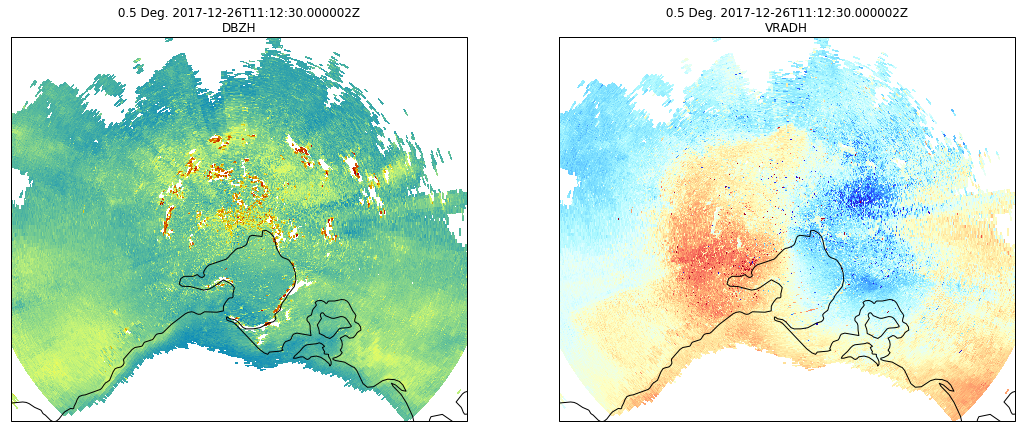

In [47]:
#download a single radar volume from a static source
radar_volume_url = 'https://s3-ap-southeast-2.amazonaws.com/public-web-data/02_20171226_111230.pvol.h5'
radar_volume_fn  = '02_20171226_111230.pvol.h5'
urllib.request.urlretrieve(radar_volume_url, radar_volume_fn)

#load radar volume
my_radar = pyart.aux_io.read_odim_h5(radar_volume_fn, file_field_names=True)
#determine plot domains
radar_lat = my_radar.latitude['data'][0]
radar_lon = my_radar.longitude['data'][0]
min_lat   = radar_lat - 1.0
max_lat   = radar_lat + 1.0
min_lon   = radar_lon - 1.5
max_lon   = radar_lon + 1.5
# Set up the GIS projection
projection = ccrs.Mercator(
                central_longitude=radar_lon,
                min_latitude=min_lat, max_latitude=max_lat)
#plotting
fig, axes = plt.subplots(1, 2, subplot_kw=dict(projection=projection), figsize=(18, 12))
display = pyart.graph.RadarMapDisplayCartopy(my_radar)
#Reflectivity
display.plot_ppi_map('DBZH', 0,
                        projection=projection, colorbar_flag=False,
                        min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
                        vmin=-8, vmax=64, cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                        resolution='10m', ax=axes[0])
#Velocity
display.plot_ppi_map('VRADH', 0,
                        projection=projection, colorbar_flag=False,
                        min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
                        vmin=-20, vmax=20, cmap=pyart.graph.cm.BuDRd12,
                        resolution='10m', ax=axes[1])
plt.show()

## What's going on here?

1. Ground clutter
1. Holes from removed ground clutter
1. Beam blockage patterns
1. Anomalous propagation
1. Lots and lots of insects

Explore the [Google Map Terrain layer](https://www.google.com/maps/@-37.8970625,144.75683,8.5z/data=!5m1!1e4) and find the terrain responsible for blocking and clutter. Also examine for possible sources of insects!

## Discussion... what can we do for Single-Pol

1. Remove ground clutter using a zero Doppler velocity and [pyart despeckle filter](http://arm-doe.github.io/pyart-docs-travis/dev_reference/generated/pyart.correct.despeckle.despeckle_field.html)
1. Fill holes using data from higher tilts
1. Calculate beam blockage loss using elevation model [using wradlib](https://docs.wradlib.org/en/stable/notebooks/beamblockage/wradlib_beamblock.html)
1. Removing anomalous propagation can be hard for single-pol. Look at vertical gradient of reflectivity, Doppler velocity and despeckle
1. Insects can be removed by looking at texture and vertical depth, but in this case they are a very low reflectivity (10 dBZ)

### Having dual-pol data makes this process much much easier